In [1]:
import numpy as np
import pandas as pd
from astropy.table import Table, vstack
from matplotlib import pyplot as plt
from glob import glob
from astropy.stats import LombScargle
from scipy import stats
import warnings
from TESStools import *
from astroML.time_series import ACF_scargle,ACF_EK

In [2]:
tid = 179305185

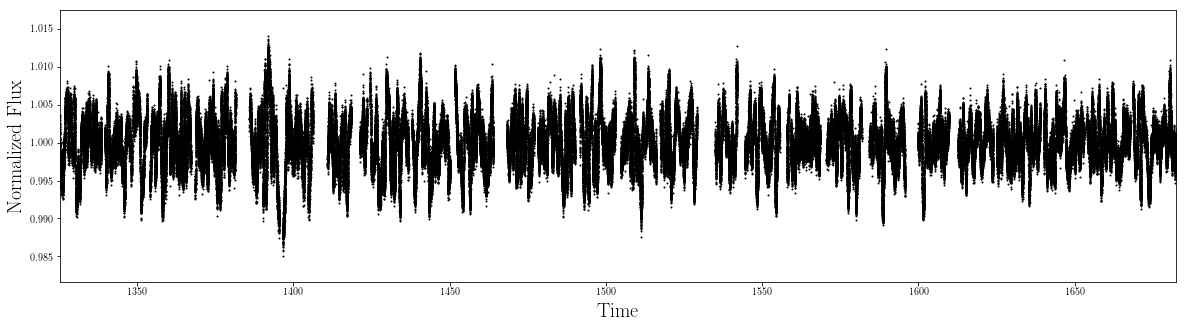

In [3]:
lc, lc_smooth = lc_extract(get_lc_from_id(tid), smooth=128)
time, flux, err = lc['Time'], lc['Flux'], lc['Err']
fig = plt.figure(figsize=(20,5))
plt.scatter(time,flux,s=1,c='k')
plt.xlim(np.min(time),np.max(time))
np.max(time) - np.min(time)
plt.xlabel('Time',fontsize=20)
plt.ylabel('Normalized Flux',fontsize=20)

In [23]:
np.floor((max_t-min_t) / dt)

9.0

In [68]:
min_t = 1.21
max_t = 11.3
dt = 2.512


array([ 1.21 ,  3.722,  6.234,  8.746, 11.258])

In [62]:
np.linspace(1.21,11.21,num=11,retstep=True)

(array([ 1.21,  2.21,  3.21,  4.21,  5.21,  6.21,  7.21,  8.21,  9.21,
        10.21, 11.21]), 1.0)

In [69]:
np.array([[1,2,3],[4,5,6]]).shape

(2, 3)

In [86]:
#sliding window periodogram
def sliding_periodogram(time, flux, err=None, window=15.0, dt=1.0, max_f=5.0):
    """
    A sliding window periodogram. Calculated over a window of width `window` days,
    every `dt` days
    
    Parameters
    ----------
    time : array-like
        times
    flux : array-like
        fluxes
    err : array-like
        errors, optional
    window : float
        width of sliding window
    dt : float
        size of step over the window
    max_f : float
        maximum frequency to calculate the Lomb-Scargle periodogram
        
    Returns
    -------
    ts : array-like
        Time values of sliding periodogram
    freq : array-like
        Frequency grid of `periodograms`
    periodograms : array-like
        Periodograms. Each entry is a periodogram corresponding to a time in `ts`. Shape is
        `(len(ts),len(freq))`
    
    """
    
    min_t = np.min(time)#+(window/2.0)
    max_t = np.max(time)#-(window/2.0)
    
    n_dt = np.floor((max_t-min_t) / dt)
    start = min_t
    stop = min_t+(n_dt*dt)
    num = int(n_dt+1)
    ts = np.linspace(start,stop,num=num)
    periodograms = []
    for i,t in enumerate(ts):
        condition = (time >= t-(window/2.0))&(time < t+(window/2.0))
        wtime = time[condition]
        wflux = flux[condition]
        if err is not None:
            werr = err[condition]
            ls = LombScargle(wtime,wflux,dy=werr)
        else:
            ls = LombScargle(wtime,wflux)
        if i == 0:
            freq,power = ls.autopower(maximum_frequency=max_f)
        else:
            power = ls.power(freq)
        periodograms.append(power)
    periodograms = np.array(periodograms)
    
    return ts, freq, periodograms

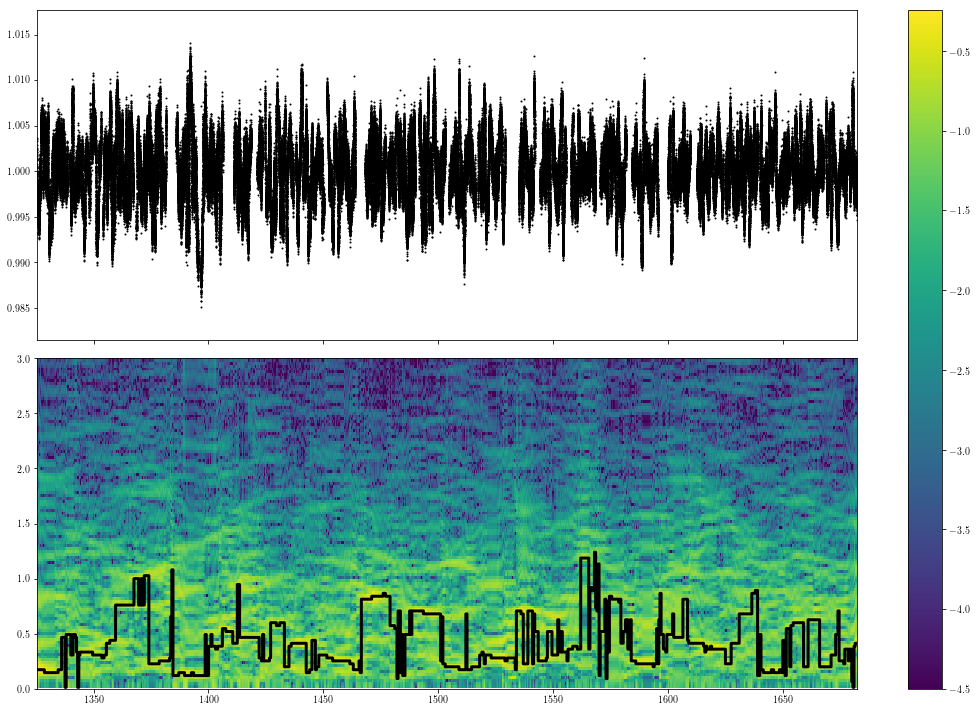

In [103]:
ts, freq, periodograms = sliding_periodogram(time,flux,err,window=15.0,dt=0.5,max_f=3.0)
fig,ax = plt.subplots(2,figsize=(15,10),sharex=True)
ax[0].scatter(time,flux,s=1,c='k')
mesh = ax[1].pcolormesh(ts,freq,np.log10(periodograms.T),vmin=-4.5)
ax[0].set(xlim=(min(time),max(time)))
max_peak = [freq[p==m][0] if not np.isnan(m) else np.nan for p,m in zip(periodograms,np.max(periodograms,axis=1))]
ax[1].step(ts,max_peak,c='k',lw=3,where='mid')
ax[1].set(ylim=(0,3))
fig.tight_layout()
plt.colorbar(mappable=mesh,ax=ax)

(array([  6., 101., 136.,  89.,  97.,  65.,  39.,  35.,  55.,  43.,  26.,
          4.,   9.,   2.,   8.]),
 array([0.01333575, 0.09512838, 0.17692101, 0.25871364, 0.34050627,
        0.4222989 , 0.50409153, 0.58588416, 0.66767679, 0.74946942,
        0.83126205, 0.91305467, 0.9948473 , 1.07663993, 1.15843256,
        1.24022519]),
 <a list of 15 Patch objects>)

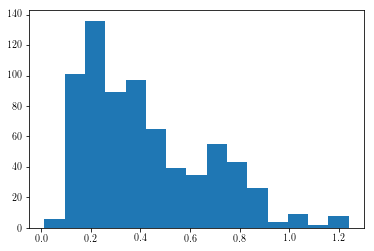

In [104]:
plt.hist(max_peak,bins='auto')

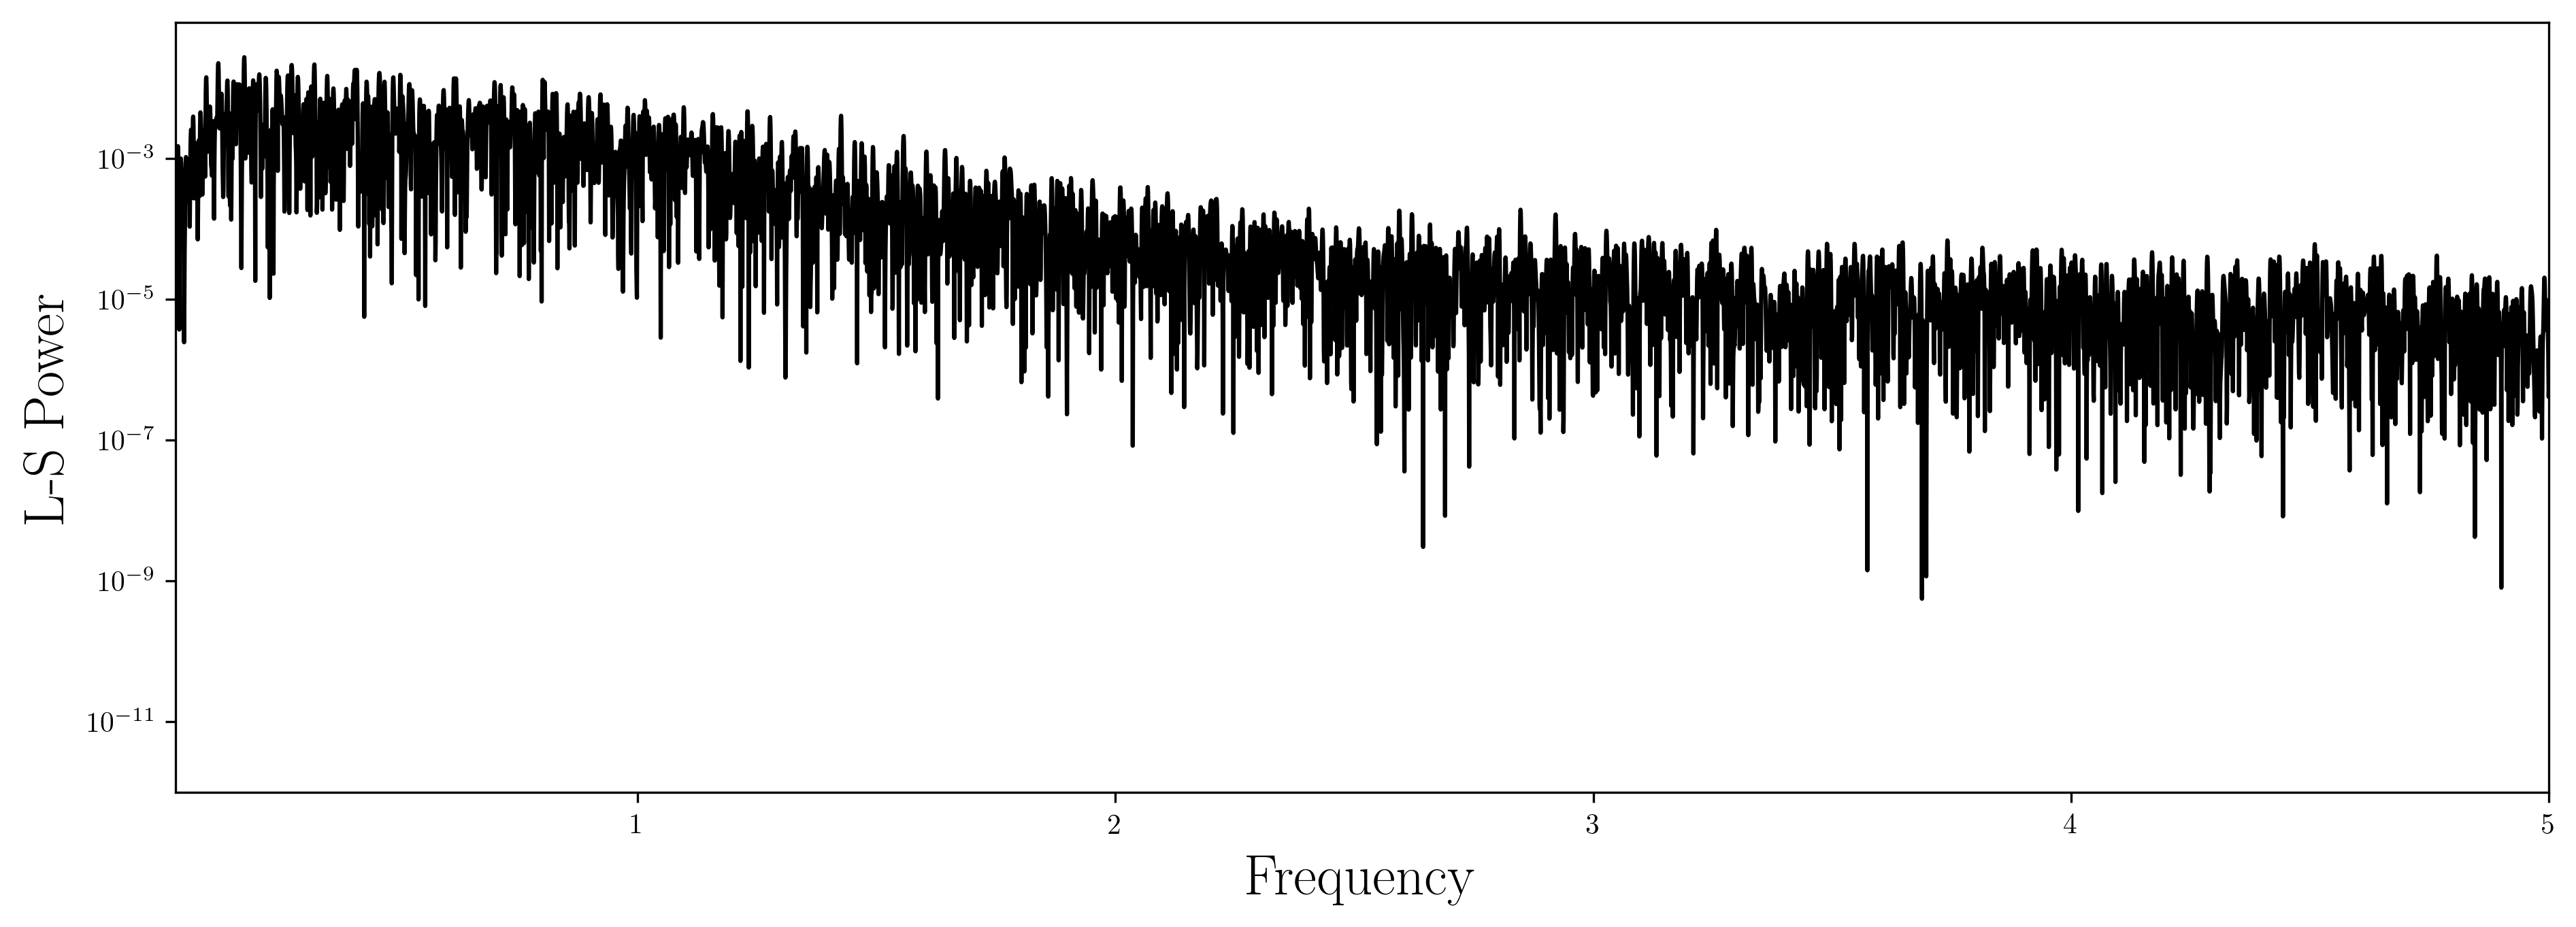

In [79]:
fig = plt.figure(figsize=(15,5),dpi=300)
pseudo_NF = 0.5 / (np.mean(np.diff(time)))
ls = LombScargle(time, flux, normalization='psd')
freq, power = ls.autopower(minimum_frequency=1.0/30.0,
                    maximum_frequency=pseudo_NF) 
plt.plot(freq,power,c='k')
#plt.xscale('log')
plt.yscale('log')
plt.xlim(1/30,5)
plt.xlabel('Frequency',fontsize=20)
plt.ylabel('L-S Power',fontsize=20)
plt.savefig('/Users/carina/Desktop/sdorgram.png')

In [3]:
lc, lc_smooth = lc_extract(get_lc_from_id(tid), smooth=128)
time, flux, err = lc['Time'], lc['Flux'], lc['Err']

pseudo_NF = 0.5 / (np.mean(np.diff(time)))
ls = LombScargle(time, flux, normalization='psd')
freq, power = ls.autopower(minimum_frequency=1.0/30.0,
                    maximum_frequency=pseudo_NF) 

good_fs, good_amps, good_phases = prewhiten(time, flux, err)
harmonics = harmonic_search(good_fs)
combos = combo_search(good_fs)

f_Ny = 322.8060468379108, f_R = 0.0177879072510214
10
20
30
40
50
60
70
Found 71 frequencies
41 unique frequencies


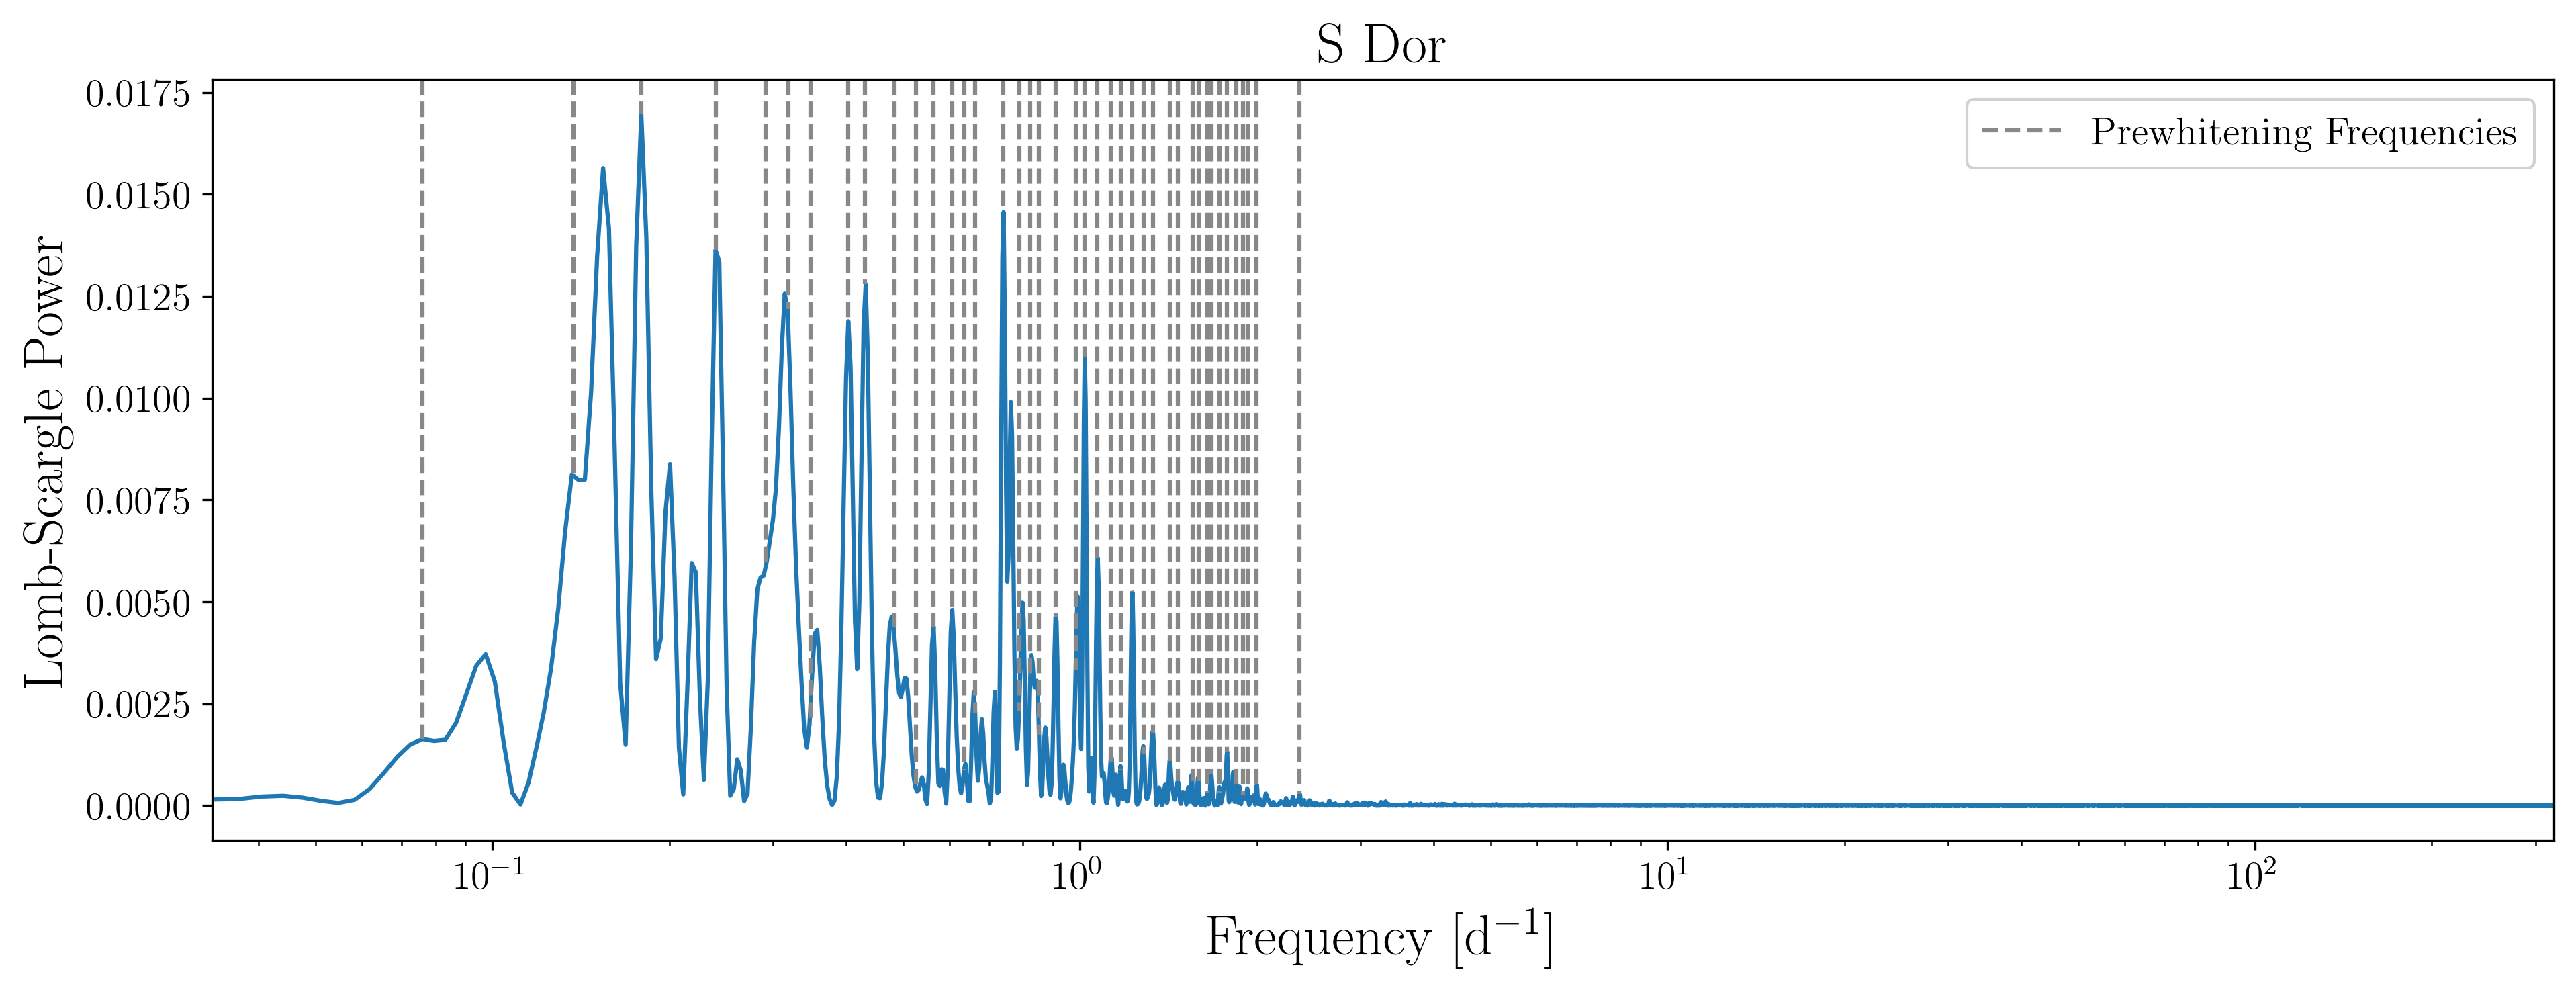

In [4]:
fig = plt.figure(figsize=(15,5),dpi=300)

plt.plot(freq, power)

ax = plt.gca()

ax.set(xlabel='Frequency [d$^{-1}$]', ylabel='Lomb-Scargle Power', xscale='log', xlim=(1/30,pseudo_NF))

ylim = ax.get_ylim()

plt.plot([good_fs[0,0],good_fs[0,0]],[ylim[1],power[np.argmin(np.abs(freq-good_fs[0,0]))]],c='#888888',ls='--',label='Prewhitening Frequencies')
for f in good_fs[1:,0]:
    plt.plot([f,f],[ylim[1],power[np.argmin(np.abs(freq-f))]],c='#888888',ls='--')
       
ax.set(ylim=ylim)
        
plt.legend(loc=1, framealpha=0.9, prop={'size': 14})

ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
    
ax.set_title('S Dor',fontsize=20) 
plt.savefig('../plots/SDor_periodogram.pdf')

/Users/carina/anaconda/lib/python3.5/site-packages/astroML/time_series/ACF.py:133: RuntimeWarning: invalid value encountered in true_divide
  ACF /= M
/Users/carina/anaconda/lib/python3.5/site-packages/astroML/time_series/ACF.py:135: RuntimeWarning: divide by zero encountered in true_divide
  return ACF, np.sqrt(2. / M), bins
/Volumes/shoobert/Research/UW/TESS/code/TESStools.py:73: RuntimeWarning: invalid value encountered in greater
  if np.all(p[i] > p[i -width:i])&np.all(p[i] > p[i + 1:i+width+1])&(p[i]>FAL):


[0.08194736 0.25312258 0.16582783 0.58976342 0.44486563]


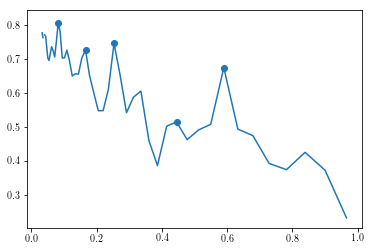

In [5]:
C_EK, C_EK_err, bins = ACF_EK(freq[freq<=2], power[freq<=2], 0.001*power[freq<=2], bins=np.logspace(-1.5, 0, 50))
f_EK = 0.5 * (bins[1:] + bins[:-1])
plt.plot(f_EK,C_EK)
f,p = peak_finder(f_EK,C_EK,10,width=3)
plt.scatter(f,p)
print(f)

In [6]:
harmonics

array([[0.07590602],
       [0.60660139],
       [8.        ]])

In [7]:
combos

array([[0.17914669, 0.17914669, 0.40287251, 0.13744498, 0.48307755,
        0.98355185, 0.98355185, 0.63478994],
       [0.48307755, 1.46672799, 1.01866464, 0.52554769, 0.98355185,
        0.60660139, 0.66258409, 1.72867338],
       [0.66258409, 1.6460147 , 1.42147429, 0.66258409, 1.46672799,
        1.59025206, 1.6460147 , 2.36401361]])

/Volumes/shoobert/Research/UW/TESS/code/TESStools.py:111: RankWarning: Polyfit may be poorly conditioned
  p = np.polyfit(lc['Time'].values,lc['Flux'].values,deg=deg)


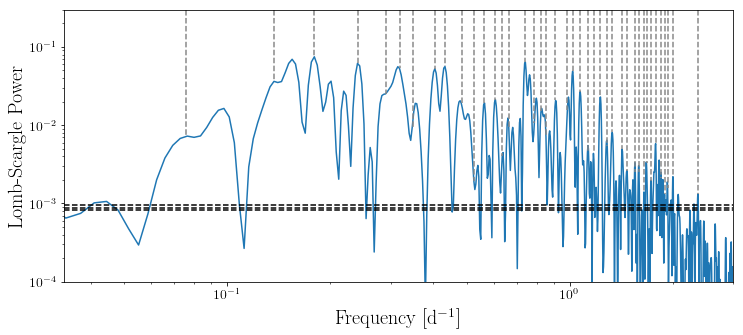

In [11]:
fig = plt.figure(figsize=(12,5))
lc, lc_smooth = lc_extract(get_lc_from_id(tid), smooth=128)
lc = polynorm(lc, deg=7)[0]
time, flux, err = lc['Time'], lc['Flux'], lc['Err']
ls = LombScargle(time, flux)
freq, power = ls.autopower() 
plt.loglog(freq, power)

ax = plt.gca()

ax.set(xlabel='Frequency [d$^{-1}$]',ylabel='Lomb-Scargle Power', xlim=(1/30,pseudo_NF))

ylim = ax.get_ylim()

plt.plot([good_fs[0,0],good_fs[0,0]],[ylim[1],power[np.argmin(np.abs(freq-good_fs[0,0]))]],c='#888888',ls='--',label='Prewhitening Frequencies')
for f in good_fs[1:,0]:
    plt.plot([f,f],[ylim[1],power[np.argmin(np.abs(freq-f))]],c='#888888',ls='--')
   
ax.set(ylim=(1e-4,ylim[1]))
ax.set(xlim=(1/30,3))

probabilities = [0.1, 0.05, 0.01]
fal = ls.false_alarm_level(probabilities)
for f in fal:
    plt.axhline(y=f,c='k',ls='--')
        
#plt.legend(loc=1, framealpha=0.9, prop={'size': 14})

ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)

In [13]:
good_fs[:,0][~np.array([power[np.argmin(np.abs(freq-f))] for f in good_fs[:,0]] >= fal[-1])]

array([], dtype=float64)